# I. Import Data & Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# More Data Preprocessing & Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cleaned_df = pd.read_csv('cleaned_df.csv')

# II. Exploratory Data Analysis

### E. Visualize & Understand (EDA)

### D. Assess Missing Values

In this section, we need to come up with a strategy on how we're going to tackle our missing values. Most ML algorithms (except fancy ones like XGBoost) cannot handle NA values, so we need to deal with them.

You have two options, and I'll describe some strategies for each option below:

#### 1 - Remove them
* Are there many missing values in a particular column? Perhaps it's not very useful if there's too many missing.
* Are there many missing values in a particular row? Perhaps this missingness caused by something reasonable or a data-collecting failure. Investigate these in case you can reasonably identify a reason why they're missing before you drop them.
* Do some rows not contain your response variable of interest? Perhaps you want to predict price of an Airbnb listing. Supervised learning methods require the label (price) to be there, so we can disregard these rows.

#### 2 - Fill them 
(**Warning:** it's generally not great practice to fill missing values before you train/test split your data. You can fill missing values now if it's a one-off analysis, but if this is something you want to implement in practice, you want to be able to test your entire preprocessing workflow to evaluate how good it is. Think of your strategy for filling missing values as another hyperparameter that you want to tune.)
* Infer the value of missing values from other columns. (e.g. If state is missing, but city is San Francisco, state is probably CA)
* Fill numerical values with mean, median, or mode.
* Fill categorical values with the most frequent value.
* Use machine learning techniques to predict missing values. (Check out IterativeImputer from sklearn for a method of doing this.)

#### Here's our approach for the section below...

* We assess missing values per column to see if we can drop any features.
* We assess missing values per row to see if we can find any patterns in how these values may be missing.
* We strategize how we want to fill our categorical features.
* We strategize how we want to fill our remaining numerical features.

**1. Assessing Missing Values per Column**

In [3]:
## Let's assume we want to predict the price feature. 
## If price is the variable we want to predict, then we have to disregard rows that don't have it
## Drop all rows with missing values in the 'price' column

cleaned_df = cleaned_df.dropna(subset=['price'])

In [4]:
# Calculating proportion by summing NA values and dividing by length of DF
prop_na = cleaned_df.isna().sum()/len(cleaned_df)
prop_na.sort_values(ascending=False).head(22)

type                   1.000000
warranty               0.818219
paint_type             0.358637
cylinders              0.348988
gears                  0.290351
vat                    0.273482
upholstery             0.236707
emission_class         0.225034
displacement           0.212888
consumption_city       0.209649
consumption_country    0.205601
consumption_comb       0.184413
co2_emission           0.152969
registration           0.097301
first_registration     0.097301
nunber_of_seats        0.059109
body_color             0.035830
number_of_doors        0.009784
body_type              0.003306
Cruise control         0.000000
Auxiliary heating      0.000000
Electric Starter       0.000000
dtype: float64

In [5]:
# Filtering out columns with less than 5% NA values to clean up the visualization below
prop_na_05 = prop_na[prop_na > 0.05]
prop_na_05 = prop_na_05.sort_values(0, ascending=True).reset_index()

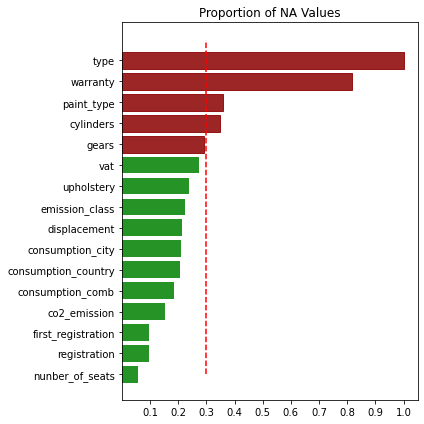

In [6]:
# Plotting proportion of NA values for all columns where more than 5% is missing. 
# The 5 columns in red will be removed since they are missing > 30% of their values.
plt.figure(figsize=(6, 6))

barh = plt.barh(prop_na_05['index'], prop_na_05[0], alpha=0.85, color='green')
for i in range(5):
    i += 1
    barh[-i].set_color('darkred')

plt.title('Proportion of NA Values')
plt.vlines(x=.3, ymin=0, ymax=16, color='red', linestyles='dashed')
plt.xticks(np.arange(.1, 1.01, .1))

plt.tight_layout()

In [7]:
## Drop the 5 missing columns identified above from cleaned_df
drop_na_cols = ['type', 'warranty', 'paint_type', 'cylinders', 'gears']

cleaned_df = cleaned_df.drop(drop_na_cols, axis=1)

**2. Assessing Missing Values per Row**

In [8]:
## Create a temporary column called "sum_na_row" in cleaned_df that contains the number of NA values per row
cleaned_df['sum_na_row'] = cleaned_df.isna().sum(axis=1)

<Figure size 432x576 with 0 Axes>

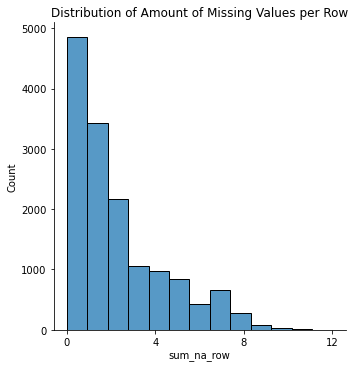

In [9]:
## Use matplotlib or seaborn to plot the distribution of this new column. 
## Hint: seaborn's distplot() function is nice and easy for this. Alternatively, countplot() may work, too

plt.figure(figsize=(6,8))
sns.displot(cleaned_df['sum_na_row'], bins=13, kde=False)
plt.xticks(np.arange(0, 16, 4))
plt.title('Distribution of Amount of Missing Values per Row')

plt.show()

we have at most 13 NaN rows. Let's continue the process by checking each line in turn.

In [10]:
## Clean_df filter for rows with 1 or more missing values. store this in a temporary DataFrame
temp = cleaned_df[cleaned_df['sum_na_row'] >= 1]

## get the names of the columns that contain missing values from this temporary DF
## Hint: DF.isna().any() can be useful here. 
na_cols = temp.columns[temp.isna().any()]

# Take a peek at what these features look like. Transposed for readability
temp[na_cols].transpose()

,3,4,5,8,9,11,12,13,14,16,...,14797,14803,14804,14807,14808,14809,14810,14813,14815,14816
number_of_doors,3.0,5.0,4.0,5.0,5.0,4.0,5.0,3.0,5.0,5.0,...,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
nunber_of_seats,4.0,5.0,5.0,4.0,4.0,NaN,5.0,4.0,4.0,4.0,...,7.0,5.0,5.0,NaN,7.0,5.0,5.0,5.0,5.0,5.0
displacement,1422.0,1422.0,1598.0,1598.0,NaN,1395.0,1395.0,1395.0,NaN,1598.0,...,1598.0,1997.0,1798.0,NaN,1798.0,1798.0,1997.0,1997.0,1997.0,1798.0
consumption_comb,3.8,4.1,3.5,3.7,NaN,4.9,4.9,NaN,4.2,3.5,...,4.7,5.3,NaN,7.4,NaN,NaN,NaN,5.3,5.3,NaN
consumption_city,4.3,4.6,4.3,4.3,NaN,6.2,6.2,NaN,100.0,4.3,...,5.1,6.2,NaN,NaN,NaN,NaN,NaN,6.2,6.2,NaN
consumption_country,3.5,3.8,3.1,3.4,NaN,4.2,4.2,NaN,3.7,3.1,...,4.4,4.7,NaN,NaN,NaN,NaN,NaN,4.7,4.7,NaN
co2_emission,99.0,109.0,92.0,97.0,NaN,112.0,112.0,NaN,99.0,92.0,...,123.0,139.0,NaN,NaN,168.0,NaN,NaN,139.0,139.0,168.0
body_type,Sedans,Sedans,Sedans,Sedans,Sedans,Sedans,Sedans,Sedans,Sedans,Sedans,...,Van,Sedans,Van,Van,Van,Van,Van,Van,Van,Van
vat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VAT deductible,VAT deductible,...,VAT deductible,VAT deductible,NaN,VAT deductible,VAT deductible,NaN,VAT deductible,VAT deductible,VAT deductible,VAT deductible
registration,2016-08-01,2016-05-01,2016-02-01,2016-02-01,2017-06-01,2016-05-01,2016-09-01,2016-06-01,2016-10-01,2018-06-01,...,NaN,NaN,2019-01-01,2019-01-01,NaN,2019-02-01,2019-05-01,NaN,NaN,2019-01-01


**When we look at the missing values here, we can evaluate all of them categorically.**

In [11]:
temp[na_cols].columns

Index(['number_of_doors', 'nunber_of_seats', 'displacement',
       'consumption_comb', 'consumption_city', 'consumption_country',
       'co2_emission', 'body_type', 'vat', 'registration',
       'first_registration', 'body_color', 'upholstery', 'emission_class'],
      dtype='object')

In [12]:
cat_cols =['number_of_doors', 'nunber_of_seats', 'displacement',
       'consumption_comb', 'consumption_city', 'consumption_country',
       'co2_emission', 'registration',
       'first_registration']
median_fill_cols =['body_type', 'vat', 'body_color', 'upholstery', 'emission_class']

**3. Categorical Features with Missing Values**

Dealing with missing categorical data can be tricky. Here are some ways you can deal with them:

* Fill with mode/most frequent value (e.g. if 70% of a column is "red", maybe you fill the remaining NA values with "red")
* Infer their value from other columns (e.g. if one feature helps you make an educated guess about the missing value)
* Create a dummy variable (e.g. if the value is missing, another dummy feature will have 1. Else, it will be 0)

>Let's take the simple most frequent approach. We'll tackle this using the SimpleImputer from sklearn after we train/test split our data.

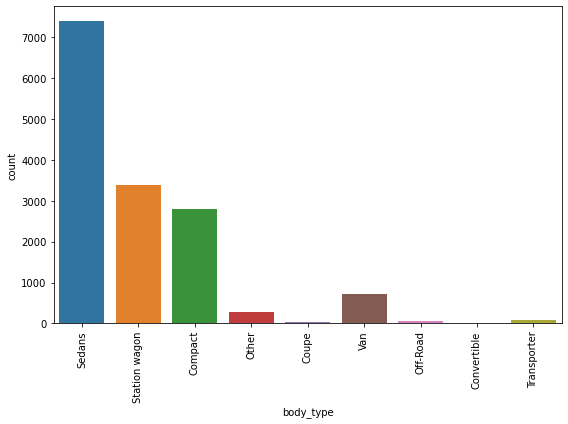

In [13]:
plt.figure(figsize=(8, 6))

sns.countplot(x = cleaned_df['body_type'])
plt.xticks(rotation=90)
plt.tick_params(labelbottom=True)

plt.tight_layout()

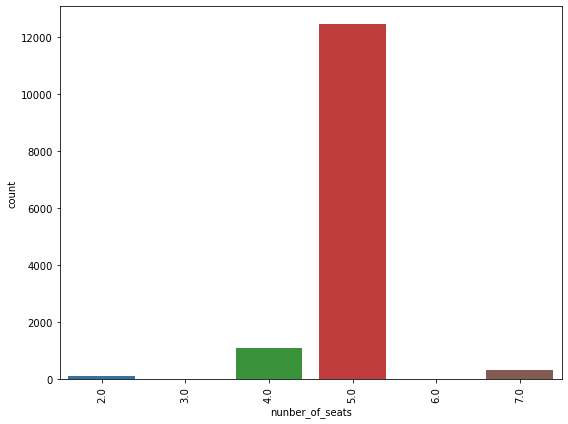

In [14]:
plt.figure(figsize=(8, 6))

sns.countplot(x = cleaned_df['nunber_of_seats'])
plt.xticks(rotation=90)
plt.tick_params(labelbottom=True)

plt.tight_layout()

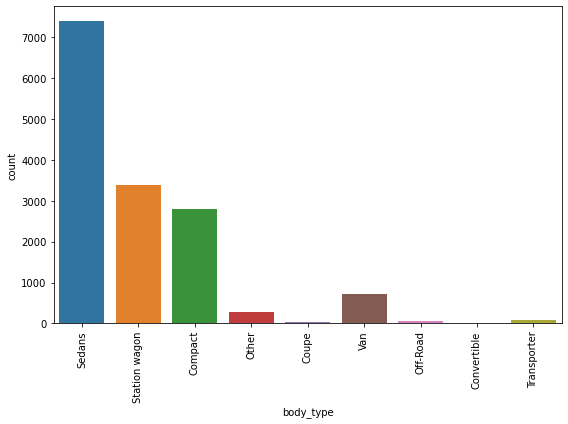

In [15]:
plt.figure(figsize=(8, 6))

sns.countplot(x = cleaned_df['body_type'])
plt.xticks(rotation=90)
plt.tick_params(labelbottom=True)

plt.tight_layout()

From the countplots above, these modes are very prominent, so let's simplify this by filling with mode.

**4. Now what should we do about imputing the rest of our missing numerical features below?**

* A lot of people like the simple approach of filling them with the mean or median of the features.
* There's also some advanced methods of imputing missing values using Machine Learning. An examle is a neat experimental estimator in sklearn called IterativeImputer that uses machine learning to predict and impute many features at once.

In [16]:
# Getting indices of columns that still contain missing values
columns_idxs_missing = np.where(cleaned_df.isna().any())[0]
# Getting the names of these columns
cols_missing = cleaned_df.columns[columns_idxs_missing]
# Taking a peek at what's left
cleaned_df[cols_missing].head()

,number_of_doors,nunber_of_seats,displacement,consumption_comb,consumption_city,consumption_country,co2_emission,body_type,vat,registration,first_registration,body_color,upholstery,emission_class
0,5.0,5.0,1422.0,3.8,4.3,3.5,99.0,Sedans,VAT deductible,2016-01-01,2016-01-01,Black,"Cloth, Black",Euro 6
1,3.0,4.0,1798.0,5.6,7.1,4.7,129.0,Sedans,Price negotiable,2017-03-01,2017-01-01,Red,"Cloth, Grey",Euro 6
2,4.0,4.0,1598.0,3.8,4.4,3.4,99.0,Sedans,VAT deductible,2016-02-01,2016-01-01,Black,"Cloth, Black",Euro 6
3,3.0,4.0,1422.0,3.8,4.3,3.5,99.0,Sedans,NaN,2016-08-01,2016-01-01,Brown,NaN,Euro 6
4,5.0,5.0,1422.0,4.1,4.6,3.8,109.0,Sedans,NaN,2016-05-01,2016-01-01,Black,"Cloth, Black",Euro 6


> Took keep things simple, let's just fill the rest of these values with the median.

In [17]:
## We don't need this column anymore
cleaned_df = cleaned_df.drop(['sum_na_row'], axis=1)

In [18]:
cat_cols = cleaned_df.select_dtypes(['object']).columns.values

In [19]:
features_accounted_for = np.concatenate([cat_cols,np.array(['price'])])
all_cols = cleaned_df.columns.values

median_fill_cols = np.setdiff1d(all_cols, features_accounted_for)

# III. Train/Test Split

Now here we split our data into training, testing, and (optionally) validation.

However, if you plan to use a validation set or K-Fold Cross Validation, just create your validation sets later when you're evaluating your ML models.

In [20]:
## TO DO: store cleaned_df without the price column in a variable called X. 
X = cleaned_df.drop('price', axis=1)
## TO DO: store cleaned_df['price'] in a variable called y
y = cleaned_df['price']

## TO DO: Split your data using train_test_split using a train_size of 80%
## TO DO: store all these in the variables below
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [21]:
# Setting this option to None to suppress a warning that we don't need to worry about right now
pd.options.mode.chained_assignment = None

# IV. Prepare for ML

Now that we've already split our data and engineered the features that we want, all we have to do is prepare our data for our models

### A. Dealing with Missing Data

The reason we want to deal with missing data after we've split our data is because we want to simulate real world conditions when we test as much as we can. When data is coming/streaming in, we have to be ready with our methods for dealing with missing data.

Below, rather than using panda's fillna method, we will take advantage of sklearn's SimpleImputer estimator (imputing is just another way of saying you're going to fill/infer missing values in this case).

***

**A Brief Note on sklearn Estimators/Transformers**

Many of sklearn's objects are called "estimators", and all estimators are also "transformers" because they are treated as objects that estimate some parameters about your data, then are used to transform your data in some way to produce a prediction or a transformed (e.g. normalized, standardized, filled NA's with mean, etc) version of your data.

***

We will fit three SimpleImputer objects on X_train only according to each of our three strategies above. Then, we will use these imputers to transform both our X_train and X_test. As a reminder, this is what we will do...

1. Fill categorical features stored in cat_cols with their mode/most frequent value
2. Fill review-related features stored in zero_fill_cols with a constant vaue: 0.
3. Fill all remaining numerical features stored in median_fill_cols with their median.
>This is why we stored these column names in the Assess Missing Values section. We want to easily change each of these columns for both our X_train and X_test datasets.

In [22]:
median_fill_cols =['number_of_doors', 'nunber_of_seats', 'displacement',
       'consumption_comb', 'consumption_city', 'consumption_country',
       'co2_emission']
cat_cols =['body_type', 'vat', 'body_color', 'upholstery', 'emission_class', 'registration',
       'first_registration']

**First, let's start with imputing our categorical variables.**

In [23]:

## DO NOT CHANGE - use this as an example of you have to do in the cells below.
    ## Notice how we're looping through our columns, imputing one at a time.
    ## Normally, we would fit and transform features all at once with sklearn's ColumnTransformer, but 
    ## this is fine since we're just practicing

# looping through our columns
for col in cat_cols:
    # instantiating/creating an imputer with an impute strategy of "most frequent"
    imputer = SimpleImputer(strategy='most_frequent')
    
    # fit this imputer to the training column. 
        # This stores the most frequent value in the imputer for transforming
    imputer.fit(X_train[[col]])
    
    # using the transform method to fill NA values with the most frequent value, then updating our DFs
    X_train[col] = imputer.transform(X_train[[col]])
    X_test[col] = imputer.transform(X_test[[col]])

***

**Now let's impute our numerical variables.**

In [24]:
## TO DO: impute the median_fill_cols using an imputer with strategy = "median"
for col in median_fill_cols:
    imputer = SimpleImputer(strategy='median')
    imputer.fit(X_train[[col]])
    
    X_train[col] = imputer.transform(X_train[[col]])
    X_test[col] = imputer.transform(X_test[[col]])

In [26]:
prop_na = X_train.isna().sum()/len(X_train)
prop_na.sort_values(ascending=False).head(5)

km                               0.0
Electrically adjustable seats    0.0
Electric tailgate                0.0
Electric Starter                 0.0
Cruise control                   0.0
dtype: float64

In [29]:
prop_na = X_test.isna().sum()/len(X_test)
prop_na.sort_values(ascending=False).head(5)

km                               0.0
Electrically adjustable seats    0.0
Electric tailgate                0.0
Electric Starter                 0.0
Cruise control                   0.0
dtype: float64